In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import hls4ml
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

2023-04-20 16:22:26.716136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 16:22:26.716152: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ej/workspace/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

x_train = x_train[:,:100:2]
x_test = x_test[:,:100:2]


n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [3]:
model = load_model('timeseries_3b_l50.h5')

2023-04-20 16:22:27.973492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 16:22:27.973929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 16:22:27.973975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-20 16:22:27.974015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-20 16:22:27.974053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 1)       337         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 50, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 dense (Dense)                  (None, 50, 4)        8           ['dropout[0][0]']            

In [5]:
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)

4/4 [==============================] - 0s 5ms/step


In [6]:
auc_arr = np.array([])
int_bit = 6
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'CE_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,10>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 1024
        if 'dense' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 1024
            hls_config['LayerName'][Layer]['exp_range'] = 4
    print(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' 
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

In [7]:
print(auc_arr)
int6 = auc_arr

[0.52975 0.6769  0.5251  0.9718  0.99765 0.99785 0.997   0.99655 0.99625]


In [8]:
auc_arr = np.array([])
int_bit = 7
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'CE_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,10>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 1024
        if 'dense' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 1024
            hls_config['LayerName'][Layer]['exp_range'] = 4
    print(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' 
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

In [9]:
print(auc_arr)
int7 = auc_arr

[0.52975 0.6769  0.5251  0.9718  0.99765 0.99785 0.997   0.99655 0.99625]


In [10]:
auc_arr = np.array([])
int_bit = 8
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'CE_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,10>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 1024
        if 'dense' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 1024
            hls_config['LayerName'][Layer]['exp_range'] = 4
    print(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' 
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

In [11]:
print(auc_arr)
int8 = auc_arr

[0.52975 0.6769  0.5251  0.9718  0.99765 0.99785 0.997   0.99655 0.99625]


In [12]:
auc_arr = np.array([])
int_bit = 9
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'CE_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,10>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 1024
        if 'dense' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 1024
            hls_config['LayerName'][Layer]['exp_range'] = 4
    print(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' 
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

In [13]:
print(auc_arr)
int9 = auc_arr

[0.52975 0.6769  0.5251  0.9718  0.99765 0.99785 0.997   0.99655 0.99625]


In [14]:
auc_arr = np.array([])
int_bit = 10
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'CE_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,10>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 1024
        if 'dense' in Layer:
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 1024
            hls_config['LayerName'][Layer]['exp_range'] = 4
    print(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' 
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6,

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
Layer name: add, layer type: Add
Layer name: add_1, layer type: Add
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (linear), layer name: dense_3
Layer name: add_2, layer type: Add
Layer name: add_3, layer type: Add
Layer name: multi_head_attention_2, layer type: MultiHeadAttention
Layer name: dense_4, layer type: Dense
  -> Activation (relu), layer name: dense_4
Layer name: dense_5, layer type: Dense
  -> Activation (linear), layer name: dense_5
Layer name: add_4, layer type: Add
Layer name: add_5, layer type: Add
Layer name: dense_6, laye

In [15]:
print(auc_arr)
int10 = auc_arr

[0.52975 0.6769  0.5251  0.9718  0.99765 0.99785 0.997   0.99655 0.99625]


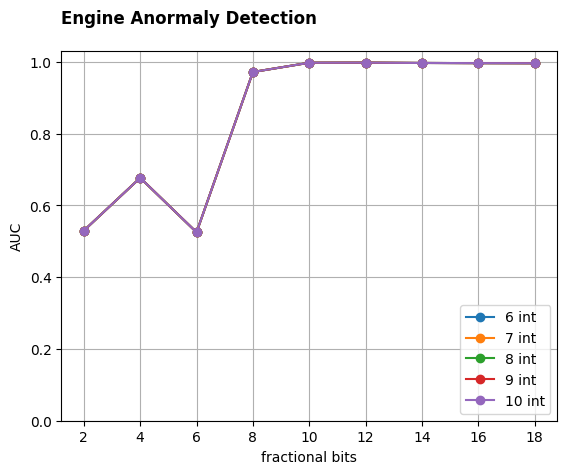

In [19]:
fig, ax = plt.subplots()
x_axis = [2,4,6,8,10,12,14,16,18]
ax.plot(x_axis, int6, "-o", label = "6 int")
ax.plot(x_axis, int7, "-o", label = '7 int')
ax.plot(x_axis, int8, "-o", label = '8 int')
ax.plot(x_axis, int9, "-o", label = '9 int')
ax.plot(x_axis, int10, "-o", label = '10 int')

ax.legend(loc='lower right')
ax.set_xlabel("fractional bits")
ax.set_ylabel("AUC")

# Set the title and adjust its position 
ax.set_title("Engine Anormaly Detection", loc='left', fontweight='bold', pad=20)

ax.grid()
ax.set_ylim([0.0, 1.03])
plt.show()